# Sentiment Analysis in Python 👩🏻‍💻✨🤍
### Amazon: food reviews and ratings

Techniques used:
1. VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
2. Roberta Pretrained Model from Hugging Face
3. Hugging Face Pipeline

### Imports

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
import os

In [28]:
# Read in data

df = pd.read_csv("/Users/ana/Desktop/data-science-project/data/Reviews.csv")

In [29]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [30]:
df['Text'].values[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [31]:
df = df.head(50)
print(df.shape)

(50, 10)


## EDA

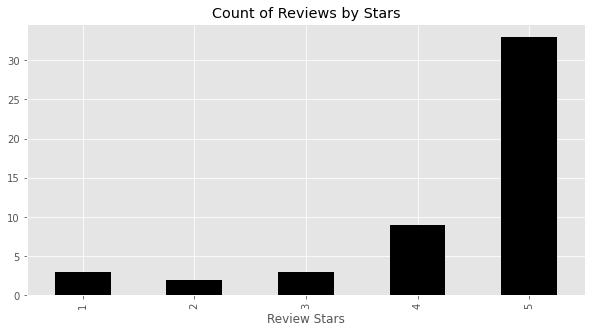

In [32]:
color = 'black'
ax = df['Score'].value_counts().sort_index().plot(kind='bar', title='Count of Reviews by Stars', 
                                             figsize=(10,5), color=color)
ax.set_xlabel('Review Stars')
plt.show()

### Basic NLTK

In [33]:
example = df['Text'][5]
print(example)

I got a wild hair for taffy and ordered this five pound bag. The taffy was all very enjoyable with many flavors: watermelon, root beer, melon, peppermint, grape, etc. My only complaint is there was a bit too much red/black licorice-flavored pieces (just not my particular favorites). Between me, my kids, and my husband, this lasted only two weeks! I would recommend this brand of taffy -- it was a delightful treat.


In [34]:
# Word tokenizer for the purpose of splitting sentences into words, or lists of substrings 
# so to make it more understandable
tokens = nltk.word_tokenize(example)
tokens[:10]

['I', 'got', 'a', 'wild', 'hair', 'for', 'taffy', 'and', 'ordered', 'this']

In [35]:
#Part of Speech tagging/values
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('I', 'PRP'),
 ('got', 'VBD'),
 ('a', 'DT'),
 ('wild', 'JJ'),
 ('hair', 'NN'),
 ('for', 'IN'),
 ('taffy', 'NN'),
 ('and', 'CC'),
 ('ordered', 'VBD'),
 ('this', 'DT')]

In [36]:
# Identify named entities
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  I/PRP
  got/VBD
  a/DT
  wild/JJ
  hair/NN
  for/IN
  taffy/NN
  and/CC
  ordered/VBD
  this/DT
  five/CD
  pound/NN
  bag/NN
  ./.
  The/DT
  taffy/NN
  was/VBD
  all/DT
  very/RB
  enjoyable/JJ
  with/IN
  many/JJ
  flavors/NNS
  :/:
  watermelon/NN
  ,/,
  root/NN
  beer/NN
  ,/,
  melon/NN
  ,/,
  peppermint/NN
  ,/,
  grape/NN
  ,/,
  etc/FW
  ./.
  My/PRP$
  only/JJ
  complaint/NN
  is/VBZ
  there/EX
  was/VBD
  a/DT
  bit/NN
  too/RB
  much/JJ
  red/black/NN
  licorice-flavored/JJ
  pieces/NNS
  (/(
  just/RB
  not/RB
  my/PRP$
  particular/JJ
  favorites/NNS
  )/)
  ./.
  Between/IN
  me/PRP
  ,/,
  my/PRP$
  kids/NNS
  ,/,
  and/CC
  my/PRP$
  husband/NN
  ,/,
  this/DT
  lasted/VBN
  only/RB
  two/CD
  weeks/NNS
  !/.
  I/PRP
  would/MD
  recommend/VB
  this/DT
  brand/NN
  of/IN
  taffy/NN
  --/:
  it/PRP
  was/VBD
  a/DT
  delightful/JJ
  treat/NN
  ./.)


# Vader Sentiment Scoring

Using NLTK's `SentimentIntensityAnalyzer` to get the negative (neg), neutral (neu) and positive (pos) scores of the text
This uses a "bag of words approach":
* Stop words are removed
* Each word is scored and combined to a total score

This model looks at each word in the sentence/review and scores each word individually

In [37]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [38]:
sia.polarity_scores("I am so happy!")

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [39]:
sia.polarity_scores("This is the worst thing ever.")

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [40]:
sia.polarity_scores(example)

{'neg': 0.029, 'neu': 0.809, 'pos': 0.163, 'compound': 0.883}

In [41]:
# Run the polarity score on the entire dataset
results = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    results[myid] = sia.polarity_scores(text)

  0%|          | 0/50 [00:00<?, ?it/s]

In [42]:
vaders = pd.DataFrame(results).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [43]:
# Now we have sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Plot VADER results

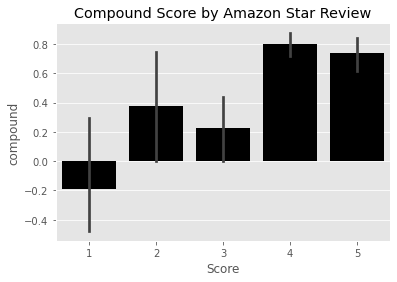

In [44]:
ax = sns.barplot(data=vaders, x='Score', y='compound', color = "black")
ax.set_title('Compound Score by Amazon Star Review')
plt.show()

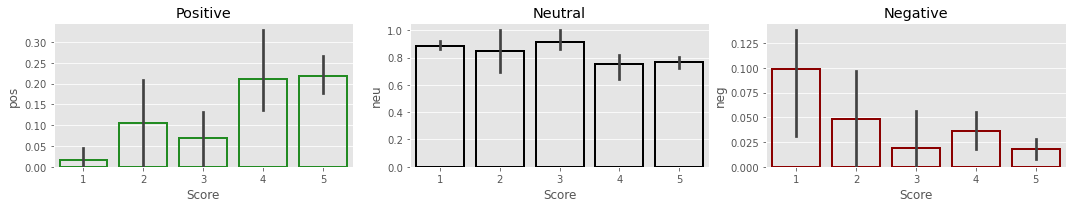

In [45]:
fig, axs = plt.subplots(1, 3, figsize=(15,3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0], linewidth=2, edgecolor="forestgreen", facecolor=(0, 0, 0, 0))
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1], linewidth=2, edgecolor="black", facecolor=(0, 0, 0, 0))
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2], linewidth=2, edgecolor="darkred", facecolor=(0, 0, 0, 0))
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Roberta Pretrained Model

* Use model trained of a large corpus data
* Transformer model accounts for the words, but also the context related to other words

In [46]:
import torch
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from transformers import RobertaTokenizerFast

In [47]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [48]:
# VADER results on example
print(example)
sia.polarity_scores(example)

I got a wild hair for taffy and ordered this five pound bag. The taffy was all very enjoyable with many flavors: watermelon, root beer, melon, peppermint, grape, etc. My only complaint is there was a bit too much red/black licorice-flavored pieces (just not my particular favorites). Between me, my kids, and my husband, this lasted only two weeks! I would recommend this brand of taffy -- it was a delightful treat.


{'neg': 0.029, 'neu': 0.809, 'pos': 0.163, 'compound': 0.883}

In [1]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
output

NameError: name 'tokenizer' is not defined